# Deep Hedging

In [2]:
# Importing Relevant Packages
## Basics
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
import numpy.matlib
import pandas as pd, scipy.stats as stats
from tqdm import tqdm
from scipy.optimize import minimize_scalar

## Pytorch Packages
import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
import torch.nn.functional as F

## CPU & other settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set_theme()
plt.rcParams["figure.figsize"] = (15,4)

# Simulators

In [3]:
class BlackScholesModel:
    def __init__(self, price, strike, riskFreeRate, dividendRate, timeToExpiry, volatility):
        self.price = price
        self.strike = strike
        self.riskFreeRate = riskFreeRate
        self.dividendRate = dividendRate
        self.timeToExpiry = timeToExpiry
        self.volatility = volatility
        
        self.d1 = ((np.log(price/strike) + (riskFreeRate + 0.5 * volatility ** 2) * timeToExpiry)/
              (np.sqrt(timeToExpiry) * volatility))
        
    def bs_price(self):
        self.bsPrice = (self.price * np.exp(-self.dividendRate * self.timeToExpiry) * stats.norm.cdf(self.d1) - 
                        self.strike * np.exp(- self.riskFreeRate * self.timeToExpiry) * stats.norm.cdf(self.d1 - np.sqrt(self.timeToExpiry) * self.volatility))
        
        return self.bsPrice
    
    def bs_delta_hedge(self):
        self.deltaHedge = stats.norm.cdf(self.d1)
        return self.deltaHedge

In [4]:
class bsGenerator:
    '''Object that generates price Trajectories using Black-Scholes-Merton Model (Geometric Brownian Motion).

    Args:
        initialPrice (float): The initial Stock Price
        volatility (float): The (constant) volatility constant of stock price
        timeToExpiry (float): Time in years until expiry
        riskFreeRate: The (constant) risk-free rate at which trader can borrow and lend
        numTradingDates: Discrete number of dates for which price must be simulated.
        numBatches: the number of batches that will be run
        batchSize: Number of path trajectories that will be simulated in each batch
        
    Output: 
        Torch Float Tensor of simulated Brownian Motion Path trajectories of size (batchSize, numTradingDates)
        
        '''
    def __init__(self
                 , initialPrice = 1.0
                 , volatility = 0.3
                 , timeToExpiry = 1.0
                 , riskFreeRate = 0.0
                 , numTradingDates = 100
                 , numBatches = 100
                 , batchSize = 128
                ):
        
        self.initialPrice = initialPrice
        self.volatility = volatility
        self.timeToExpiry = timeToExpiry
        self.riskFreeRate = riskFreeRate
        self.numTradingDates = numTradingDates
        self.deltaT = self.timeToExpiry / self.numTradingDates
        
        self.numBatches = numBatches
        self.batchSize = batchSize
        self.batchNo = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.batchNo >= self.numBatches:
            raise StopIteration()
        self.batchNo += 1
        
        # Black Scholes Paths created using geometric Brownian Motion
        # Closed form solution for Price Path
        logS = ((self.riskFreeRate - 0.5 * (self.volatility **2)) * self.deltaT +
                self.volatility * np.sqrt(self.deltaT) * np.random.normal(loc = 0.0, scale = 1.0
                                                                         , size = (self.numTradingDates + 1, self.batchSize)
                                                                         )
               )
        logS[0,] = np.zeros((1, self.batchSize)) # Set paths to start at initial price.
        logS = np.cumsum(logS, axis = 0)
        pricePaths = self.initialPrice * np.exp(logS).T
        timePaths = np.linspace(timeToExpiry, 0, numTradingDates + 1)
        timePaths[-1] = 0.000001
        timePaths = np.matlib.repmat(timePaths, self.batchSize, 1)
        
        blackScholesPrices = BlackScholesModel(pricePaths,
                                               self.initialPrice, self.riskFreeRate, 0, timePaths, self.volatility).bs_price()
        blackScholesDelta = BlackScholesModel(pricePaths,
                                               self.initialPrice, self.riskFreeRate, 0, timePaths, self.volatility).bs_delta_hedge()
        
        return torch.from_numpy(pricePaths).type(torch.FloatTensor)



In [325]:
class hestonGenerator:
    def __init__(self,
                 S0 = 100,              # the initial asset price
                 v0 = 0.04,             # the initial volatility
                 r = 0,                 # the risk-free rate
                 theta = 0.04,          # the long-term price variance
                 kappa = 1,             # the rate of reversion to theta
                 xi = 2,                # the volatility of sqrt(V_t)  
                 rho = -0.7,            # the correlation of Brownian motions
                 T = 1,                 # Time period
                 numTradingDays = 100,  # number of trading days
                 numBatches = 10,      
                 batchSize = 128):
        
        self.S0 = S0
        self.v0 = v0
        self.r = r
        self.theta = theta
        self.kappa = kappa
        self.xi = xi
        self.rho = rho
        self.T = T
        self.numTradingDays = numTradingDays
        
        self.batchNo = 0
        self.batchSize = batchSize
        self.numBatches = numBatches
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.batchNo >= self.numBatches:
            raise StopIteration()
        self.batchNo += 1
        
        # Heston Model Paths generated by two Brownian Motions
        dt = self.T / self.numTradingDays
        size = (self.batchSize, self.numTradingDays + 1)
        prices = np.zeros(size)
        vols = np.zeros(size)
        S_t = self.S0
        v_t = self.v0
        prices[:,0] = S_t
        vols[:,0] = v_t
        for t in range(1, self.numTradingDays + 1):
            W_t = np.random.multivariate_normal(np.array([0,0]),
                                        cov = np.array([[1, self.rho],[self.rho, 1]]),
                                        size = self.batchSize) * np.sqrt(dt)
            
            S_t = S_t * (np.exp((self.r - v_t/2)*dt + np.sqrt(v_t)*W_t[:,0]))
            v_t = np.abs(v_t + self.kappa*(self.theta - v_t)*dt + self.xi*np.sqrt(v_t)*W_t[:,1])
            prices[:,t] = S_t
            vols[:,t] = v_t
    

        return torch.from_numpy(prices).type(torch.FloatTensor)
    

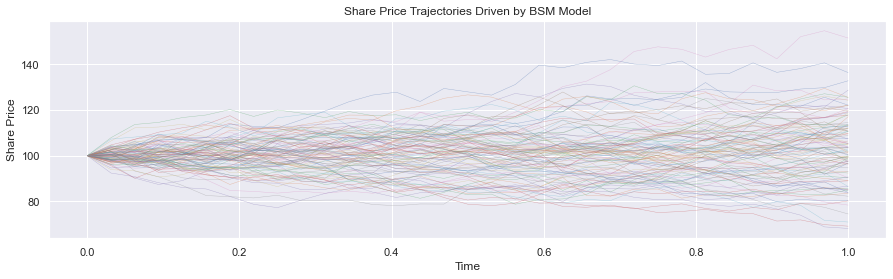

In [386]:
riskFreeRate = 0.0
volatility = 0.15
timeToExpiry = 1
initialPrice = 100
numTradingDates = 32
batchSize = 100
numBatches = 50
strike = 1

pathSimulations = bsGenerator(riskFreeRate = riskFreeRate
                             , volatility = volatility
                             , timeToExpiry = timeToExpiry
                             , initialPrice = initialPrice
                             , numTradingDates = numTradingDates
                             , batchSize = batchSize
                             , numBatches = numBatches)

for S in pathSimulations:
    pass
for i in range(batchSize):
    plt.plot(np.linspace(0,1,numTradingDates + 1), S[i,:], alpha = 0.5, linewidth = 0.4)
    plt.xlabel('Time')
    plt.ylabel('Share Price')
    plt.title("Share Price Trajectories Driven by BSM Model")
plt.show()


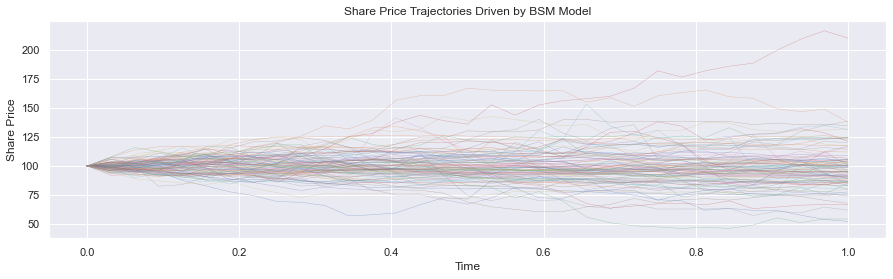

In [388]:
kappa = 0.1
theta = 0.15 ** 2
xi = 0.5
rho = 0
v_0 = 0.04

pathSimulations = hestonGenerator(S0 = initialPrice
                                 , v0 = v_0
                                 , r = riskFreeRate
                                 , theta = theta
                                 , kappa = kappa
                                 , xi = xi
                                 , rho = rho
                                 , T = timeToExpiry
                                 , numTradingDays = numTradingDates
                                 , numBatches = numBatches
                                 , batchSize = batchSize)

for S in pathSimulations:
    pass
for i in range(batchSize):
    plt.plot(np.linspace(0,1,numTradingDates + 1), S[i,:], alpha = 0.5, linewidth = 0.4)
    plt.xlabel('Time')
    plt.ylabel('Share Price')
    plt.title("Share Price Trajectories Driven by Heston Model")
plt.show()


# Simple Feed-Forward NN Strategy


In [7]:
'''This strategy does not work, and is not called upon in this project. It investigated exchange traded options,
which are marked-to-market at each rebalancing date, and took in inputs of time, option market price and time to expiry.'''

class Strategy(nn.Module):
    def __init__(self, hiddenNodes, numTradingDates, timeToExpiry, riskFreeRate):
        super(Strategy, self).__init__()
        
        # Price of the Options
        self.price = nn.Parameter(torch.tensor(0, dtype = torch.float32))
        
        # Trading/Hedging Strategy
        self.steps = nn.ModuleList()
        for i in range(numTradingDates):
            h_i = nn.Sequential(nn.Linear(3, hiddenNodes[0])
                                , nn.ReLU()
                                , nn.Linear(hiddenNodes[0], hiddenNodes[1])
                                , nn.ReLU()
                                , nn.Linear(hiddenNodes[1], hiddenNodes[2])
                                , nn.ReLU()
                                , nn.Linear(hiddenNodes[2], hiddenNodes[3])
                                , nn.ReLU()
                                , nn.Linear(hiddenNodes[3], 1)# Want Delta Value to be between [0, 1]
                               )
            
            self.steps.append(h_i)
        
        self.riskFreeRate = riskFreeRate
        self.deltaT = timeToExpiry/numTradingDates
        
    def forward(self, x): # x is a subset of paths of price process

        dS = torch.diff(x[0])
        dV = torch.diff(x[1])
        hedgingSlippage = torch.zeros_like(dS[:,0])
        tradingProfit = torch.zeros_like(dS[:,0])
        bsHedgingSlippage = torch.zeros_like(dS[:, 0])
        
        for i in range(len(self.steps)):
            Hi_old = torch.zeros_like(dS[:, 0])
            bs_old = torch.zeros_like(dS[:, 0])
            bs_hedge = x[3][:,i].unsqueeze(-1).flatten()
            logS = (x[0][:,i]).unsqueeze(-1)[0]
            logV = x[1][:,i].unsqueeze(-1)[0]
            time = x[2][:,i].unsqueeze(-1)[0]
            h_i = self.steps[i]
            H_i = h_i(torch.tensor([logS, logV, bs_hedge[0]])) 
            hedgingSlippage += (dS[:,i] * (H_i.flatten()) - dV[:, i]) * np.exp(self.riskFreeRate * time) - torch.max(torch.zeros_like(logS), logS * (H_i - Hi_old) * 0.05)
            tradingProfit += dS[:,i] * H_i.flatten()
            bsHedgingSlippage += (dS[:,i] * bs_hedge) 
            
            Hi_old = H_i.flatten()
            bs_old = bs_hedge
            
        return hedgingSlippage, tradingProfit, bsHedgingSlippage
        

In [8]:
'''This strategy is replaced by the strategy "Strategy1" '''

class StrategyMSE(nn.Module):
    def __init__(self, hiddenNodes, numTradingDates):
        super(MSEstrategy, self).__init__()
        self.steps = nn.ModuleList()
        
        for i in range(numTradingDates):
            h_i = nn.Sequential(nn.Linear(1, hiddenNodes)
                            , nn.ReLU()
                            , nn.Linear(hiddenNodes, hiddenNodes)
                            , nn.ReLU()
                            , nn.Linear(hiddenNodes, 1))
        
            self.steps.append(h_i)
        
    def forward(self, x):
        # Hedging Strategies
        nnHedge = torch.zeros_like(x[:-1])
        
        # Price Changes
        dS = torch.diff(x)
        
        # Defining updating variables
        tradingProfit = torch.zeros_like(dS[:, 0])

        
        for i in range(len(self.steps)):
            logS = torch.log(x[:,i])
            h_i = self.steps[i]
            H_i = h_i(logS.unsqueeze(-1))
            
            tradingProfit += dS[:, i] * H_i.flatten()
            bsHedgingProfit += dS[:, i] * bsHedge[:, i]
            nnHedge[:, i] = H_i.flatten()
            return tradingProfit, bsHedgingProfit, nnHedge, bsHedge

In [22]:
'''Payoff of an at-the-money European call option'''
def claim(x):
    return torch.max(x, torch.ones_like(x) * initialPrice) - initialPrice

In [10]:
'''CVaR is redefined later to for inputs from GRU unit.'''
def cVaR(hedgingSlippage, pricePaths, alpha, strike):
    profitLoss = hedgingSlippage
    conditionalVaR = - torch.mean(torch.sort(profitLoss)[0][:int((1 - alpha) * len(hedgingSlippage))])
    return conditionalVaR

In [9]:
class Strategy1(nn.Module):
    def __init__(self, hidden_nodes, no_time_steps):
        super(Strategy1, self).__init__()

        self.steps = nn.ModuleList()
        for i in range(no_time_steps):
            h_i = nn.Sequential(
                  nn.Linear(1, hidden_nodes)
                , nn.ReLU() 
                , nn.Linear(hidden_nodes, hidden_nodes)
                , nn.ReLU() 
                , nn.Linear(hidden_nodes, 1)
                )
            
            self.steps.append(h_i)
            
    def forward(self, x):
        dS  = torch.diff(x)
        hedge = torch.zeros_like(dS)
        hedgingPL = torch.zeros_like(dS[:,0])
        
        for i in range(len(self.steps)):    
            logS = torch.log((x[:,i])/x[:,0]) # Normalisation
            h_i = self.steps[i]
            H_i = h_i(logS.unsqueeze(-1))
            HedgingPL +=  dS[:,i] * H_i.flatten()
            hedge[:, i] = H_i.flatten()
        return HedgingPL, hedge

## Simple Black-Scholes World

200it [00:59,  3.35it/s]


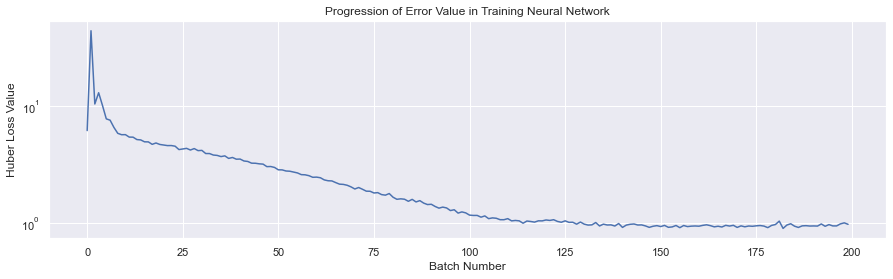

In [389]:
batchSize = 5000
numBatches = 200

progress = []
loss = nn.HuberLoss()
strat = Strategy1(100, numTradingDates)
opt = torch.optim.Adam(strat.parameters(), lr = 0.05)

for S in tqdm(bsGenerator(initialPrice = initialPrice
                          , volatility = volatility
                          , numBatches = numBatches
                          , batchSize = batchSize
                          , numTradingDates = numTradingDates)):
    opt.zero_grad()

    err = loss(strat(S)[0], claim(S[:, -1]))
    progress.append(err.item())
    err.backward()
    opt.step()
    
fig, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(np.array(progress))
plt.xlabel("Batch Number")
plt.ylabel("Huber Loss Value")
plt.title("Progression of Error Value in Training Neural Network")
plt.show()

In [390]:
timePaths = np.linspace(timeToExpiry, 0, numTradingDates + 1)
timePaths[-1] = 0.000001
timePaths = np.matlib.repmat(timePaths, 5000, 1)
blackScholesDelta = BlackScholesModel(S, initialPrice, riskFreeRate, 0, timePaths, volatility).bs_delta_hedge()
blackScholesPrice = BlackScholesModel(S[:, 0], initialPrice, riskFreeRate, 0, timeToExpiry, volatility).bs_price()

dS = np.diff(S, axis = 1)
blackScholesHedgingProfit = np.sum(blackScholesDelta[:,:-1] * dS, axis = 1) + blackScholesPrice.detach().numpy()

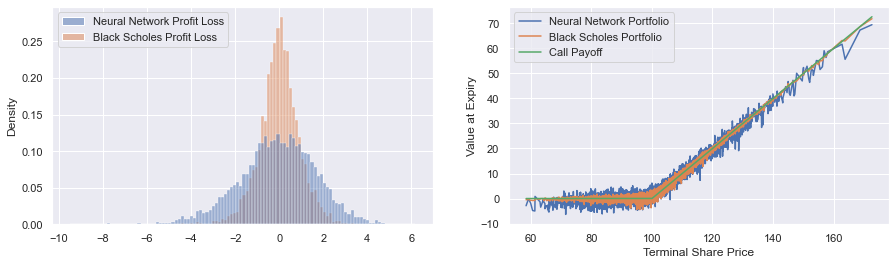

In [400]:
fig, ax = plt.subplots(1,2)
results = pd.DataFrame([strat(S)[0].detach().numpy() - claim(S[:,-1]).detach().numpy()
                        , blackScholesHedgingProfit - claim(S[:,-1]).detach().numpy()]).transpose()

results.columns = ['Neural Network Profit Loss', 'Black Scholes Profit Loss']
with torch.no_grad():
    sns.histplot(results, stat = 'density', ax = ax[0])
    plt.xlabel('Terminal Share Price')
    plt.ylabel('Value at Expiry')
    sns.lineplot(x = S[:,-1], y = strat(S)[0], ax=ax[1])
    sns.lineplot(x = S[:, -1], y = blackScholesHedgingProfit, ax = ax[1])
    sns.lineplot(x = S[:,-1], y = claim(S[:,-1]), ax=ax[1])
    plt.legend(['Neural Network Portfolio', 'Black Scholes Portfolio', 'Call Payoff'])
plt.show()

In [381]:
[np.mean(results), np.var(results), - np.mean(np.sort(results)[:int(0.5 * len(S)), 0])]

[Neural Network Hedge   -0.039642
 Black Scholes Hedge     0.006934
 dtype: float64,
 Neural Network Hedge    1.588549
 Black Scholes Hedge     0.779085
 dtype: float64,
 0.3604912372677429]

## Heston Model Price Process

200it [00:58,  3.42it/s]


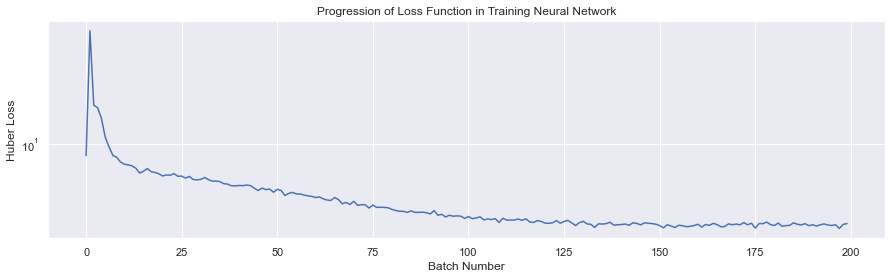

In [401]:
batchSize = 5000
numBatches = 200

progress = []
loss = nn.HuberLoss()
#strat = Strategy([192, 96, 48, 24], numTradingDates, timeToExpiry, riskFreeRate)
strat = Strategy1(100, numTradingDates)
opt = torch.optim.Adam(strat.parameters(), lr = 0.05)

for S in tqdm(hestonGenerator(S0 = initialPrice
                                 , v0 = v_0
                                 , r = riskFreeRate
                                 , theta = theta
                                 , kappa = kappa
                                 , xi = xi
                                 , rho = rho
                                 , T = timeToExpiry
                                 , numTradingDays = numTradingDates
                                 , numBatches = numBatches
                                 , batchSize = batchSize)):
    opt.zero_grad()

    err = loss(strat(S)[0], claim(S[:, -1]))
    #err = cVaR(strat(S)[0], S[0], 0.5, strike)
    progress.append(err.item())
    err.backward()
    opt.step()
    
fig, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(np.array(progress))
plt.xlabel("Batch Number")
plt.ylabel("Huber Loss")
plt.title("Progression of Loss Function in Training Neural Network")
plt.show()

In [403]:
timePaths = np.linspace(timeToExpiry, 0, numTradingDates + 1)
timePaths[-1] = 0.000001
timePaths = np.matlib.repmat(timePaths, batchSize, 1)
blackScholesDelta = BlackScholesModel(S, initialPrice, riskFreeRate, 0, timePaths, np.sqrt(theta)).bs_delta_hedge()
blackScholesPrice = BlackScholesModel(S[:, 0], initialPrice, riskFreeRate, 0, timeToExpiry, np.sqrt(theta)).bs_price()

dS = np.diff(S, axis = 1)
blackScholesHedgingProfit = np.sum(blackScholesDelta[:,:-1] * dS, axis = 1) + blackScholesPrice.detach().numpy()

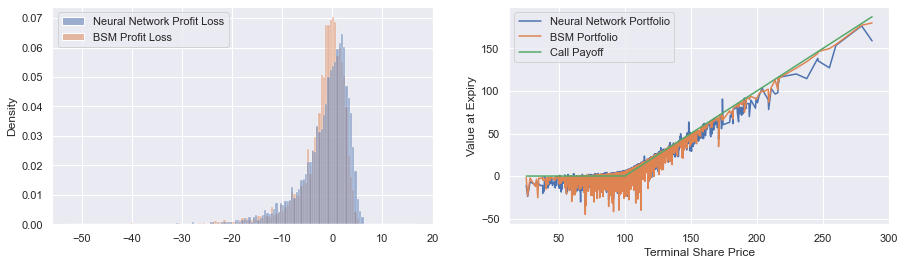

In [404]:

fig, ax = plt.subplots(1,2)
profitLoss = pd.DataFrame([strat(S)[0].detach().numpy() - claim(S[:,-1]).detach().numpy()
                        , blackScholesHedgingProfit - claim(S[:,-1]).detach().numpy()]).transpose()

hedgingProfile = pd.DataFrame([S[:, -1], strat(S)[0], blackScholesHedgingProfit, claim(S[:, -1])]).transpose()
profitLoss.columns = [ 'Neural Network Profit Loss', 'BSM Profit Loss']
hedgingProfile.columns = ['Terminal Prices', 'Neural Network', 'Black Scholes Hedge', 'Call Payoff']
with torch.no_grad():
    sns.histplot(profitLoss, stat = 'density', ax = ax[0])
    plt.xlabel('Terminal Share Price')
    plt.ylabel('Value at Expiry')
    sns.lineplot(x = S[:, -1], y = strat(S)[0], ax=ax[1])
    sns.lineplot(x = S[:, -1], y = blackScholesHedgingProfit, ax=ax[1])
    sns.lineplot(x = S[:, -1], y = claim(S[:, -1]), ax=ax[1])
    plt.legend(labels = ['Neural Network Portfolio', 'BSM Portfolio', 'Call Payoff'])

plt.show()

In [415]:
[np.mean(profitLoss), np.var(profitLoss)]

[Neural Network Profit Loss   -1.430125
 BSM Profit Loss              -1.864863
 dtype: float64,
 Neural Network Profit Loss    25.732158
 BSM Profit Loss               24.949596
 dtype: float64]

## Gated Recurrent Unit (GRU)

In [356]:
class NetworkGRU(nn.Module):
    def __init__(self, hiddenNodes):
        super(NetworkGRU, self).__init__()
        
        self.network = nn.GRU(1
                              , hiddenNodes
                              , 2
                              , batch_first = True)
        
        self.out = nn.Sequential(nn.Linear(hiddenNodes, 1), nn.Sigmoid())
        
    def forward(self, x):
        out, hidden = self.network(x) # Normalisation and Entering Network
        deltaValues = self.out(out[:, :, :])
        return deltaValues

In [352]:
def cVaR(deltaValues, S, alpha):
    dS = torch.diff(S.T, axis = 0)
    hedgingProfits = torch.sum(dS * deltaValues[:-1, :,0], axis = 0) - claim(S[:, -1])
    cvar = -torch.mean(torch.sort(hedgingProfits)[0][:int((1 - alpha) * len(dS))])
    return cvar

100it [09:37,  5.77s/it]


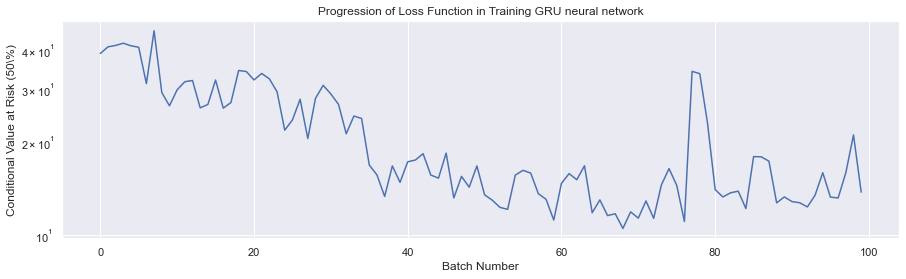

In [438]:
numBatches = 100
batchSize = 5000
progress = []
loss = nn.HuberLoss()
stratGRU = NetworkGRU(100)
opt = torch.optim.Adam(stratLSTM.parameters(), lr = 0.01)

for S in tqdm(bsGenerator(initialPrice = initialPrice
                          , volatility = volatility
                          , numBatches = numBatches
                          , batchSize = batchSize
                          , numTradingDates = numTradingDates)):
    opt.zero_grad()
    dS = torch.diff(S.T, axis = 0)
    deltaValues = stratGRU(S.T[:, :, None])[:,:]
    hedgingProfits = torch.sum(dS * deltaValues[:-1, :,0], axis = 0)
    #err = loss(hedgingProfits, claim(S[:,-1]))
    err = cVaR(deltaValues, S, 0.5)
    progress.append(err.item())

    err.backward()
    opt.step()
    
fig, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(np.array(progress))
plt.xlabel("Batch Number")
plt.ylabel("Conditional Value at Risk (50\%)")
plt.title("Progression of Loss Function in Training GRU neural network")
plt.show()

In [439]:
cVaR(deltaValues, S, 0.5)

tensor(12.8964, grad_fn=<NegBackward0>)

In [440]:
## Black Scholes Hedging Profit
timePaths = np.linspace(timeToExpiry, 0, numTradingDates + 1)
timePaths[-1] = 0.000001
timePaths = np.matlib.repmat(timePaths, batchSize, 1)
blackScholesDelta = BlackScholesModel(S, initialPrice, riskFreeRate, 0, timePaths, volatility).bs_delta_hedge()
blackScholesPrice = BlackScholesModel(S[:, 0], initialPrice, riskFreeRate, 0, timeToExpiry, volatility).bs_price()

dS = np.diff(S, axis = 1)
blackScholesHedgingProfit = np.sum(blackScholesDelta[:,:-1] * dS, axis = 1) + blackScholesPrice.detach().numpy()

## LSTM Hedging Profit
dS = torch.diff(S.T, axis = 0)
hedgingProfits = torch.sum(dS * deltaValues[:-1, :,0], axis = 0)
hedgingProfitLSTM = hedgingProfits.detach().numpy() + blackScholesPrice.detach().numpy()

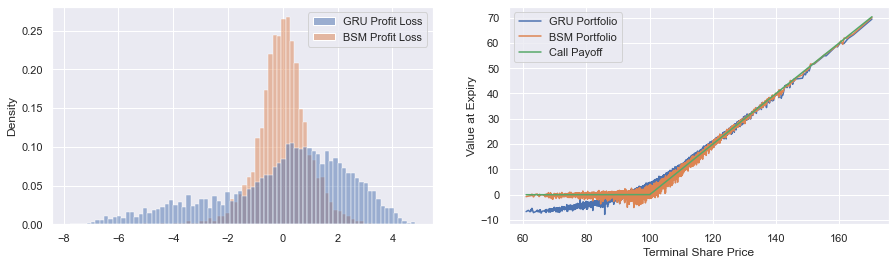

In [441]:
fig, ax = plt.subplots(1,2)
profitLossLSTM = pd.DataFrame([hedgingProfitLSTM - claim(S[:,-1]).detach().numpy()
                        , blackScholesHedgingProfit - claim(S[:,-1]).detach().numpy()]).transpose()

profitLossLSTM.columns = ['GRU Profit Loss', 'BSM Profit Loss']
with torch.no_grad():
    sns.histplot(profitLossLSTM, stat = 'density', ax = ax[0])
    plt.xlabel('Terminal Share Price')
    plt.ylabel('Value at Expiry')
    sns.lineplot(x = S[:, -1], y = hedgingProfitLSTM, ax=ax[1])
    sns.lineplot(x = S[:, -1], y = blackScholesHedgingProfit, ax=ax[1])
    sns.lineplot(x = S[:, -1], y = claim(S[:, -1]), ax=ax[1])
    plt.legend(labels = ['GRU Portfolio', 'BSM Portfolio', 'Call Payoff'])

plt.show()

In [443]:
[np.mean(profitLossLSTM),
np.var(profitLossLSTM)]

[GRU Profit Loss    0.009035
 BSM Profit Loss    0.000548
 dtype: float64,
 GRU Profit Loss    5.827344
 BSM Profit Loss    0.841739
 dtype: float64]

In [432]:
blackScholesCVaR = - np.mean(np.sort(blackScholesHedgingProfit)[:int(0.5 * len(S))])
LSTMCVaR = - np.mean(np.sort(profitLossLSTM)[:int(0.5 * len(S)), 0])
[blackScholesCVaR, LSTMCVaR]

[0.15974002259807749, 0.670559734284991]